# Learning the topology of a Bayesian Network from a database of cases using the K2 algorithm

In [16]:
library(tidyverse)

# Installed just by typing install.packages('bnlearn')
library(bnlearn)

# This was a bit more complicated to install:
# install.packages("BiocManager")
# BiocManager::install("Rgraphviz")
library(Rgraphviz)

## Some theory

The problem of finding the best belief-network structure $B_S$ is a maximization problem of the quantity:

$$P(B_S|D)\propto P(B_S,D)$$

$$\max{\left[P(B_S|D)\right]}\leftrightarrow \max{\left[P(B_S,D)\right]}$$

Robinson formula computes the number of possible Networks given the number of nodes. It is relevant to show how quickly the problem tackled scales when the number of nodes _n_ increases.

As shown in the next cell, the complexity of this task is exponential.

In [11]:
# Robinson recursive formula to compute the number of possible belief-network stuctures
# that contains n nodes
# From: A Bayesian Method for the Induction of Probabilistic Networks from Data, p. 319
n.networks.structure <- function(n)
    {
        if(n <= 1){return(1)}
        else
            {
                i <- 1
                res <- 0
                while(i <= n)
                    {
                        res <- res + ((i%%2)*2 - 1)*(choose(n,i)*(2^(i*(n-i)))*n.networks.structure(n-i))
                        i <- i + 1
                    }

                return(res)
            }
    }

for(i in 1:8)
    {
        cat('For n=',i,'the number of possible structures is: ',n.networks.structure(i),'\n')
    }


For n= 1 the number of possible structures is:  1 
For n= 2 the number of possible structures is:  3 
For n= 3 the number of possible structures is:  25 
For n= 4 the number of possible structures is:  543 
For n= 5 the number of possible structures is:  29281 
For n= 6 the number of possible structures is:  3781503 
For n= 7 the number of possible structures is:  1138779265 
For n= 8 the number of possible structures is:  783702329343 


$$P(B_S,D)=P(B_S)\prod_{i=1}^n\prod_{j=1}^{q_i}\frac{(r_i-1)!}{(N_{ij}+r_i - 1)!}\prod_{k=1}^{r_i}N_{ijk}!$$

* $P(B_S)$ is the prior probability of the model, if we assume every model to be as likely as the others then it is just a constant
* $r_i$ is the number of possible value assignments of the i-th variable
* $\pi_i$ is the set of parents for the node i
* $q_i$ the number of unique instantiations of $\pi_i$ relative to D
* $w_{ij}$ denotes the jth unique instantiation of $\pi_i$ relative to D
* $N_{ijk}$ is the number of cases in D in which the variable $x_i$ has the value $v_{ik}$ and $\pi_i$ is instantiated as $w_{ij}$
* $N_{ij}=\sum_{k=1}^{r_i}N_{ijk}$

In [55]:
ex <- read.table("./dataset/cooper.txt", header = TRUE, stringsAsFactors = TRUE)
ex

X1,X2,X3
<int>,<int>,<int>
1,0,0
1,1,1
0,0,1
1,1,1
0,0,0
0,1,1
1,1,1
0,0,0
1,1,1


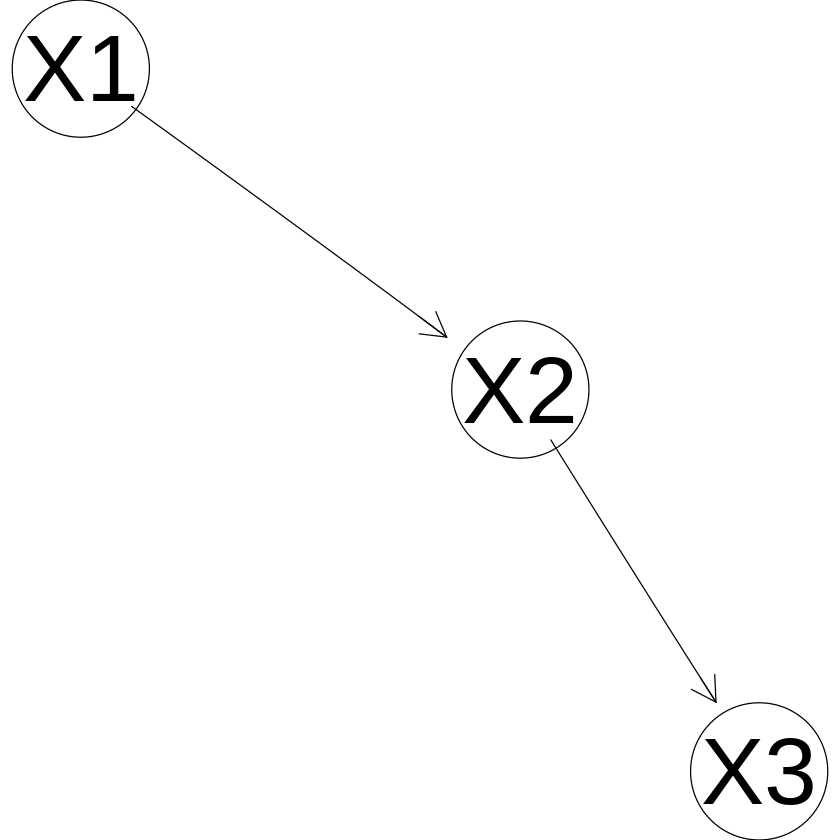

In [141]:
ex.bn1 <- model2network("[X1][X2|X1][X3|X2]")
graphviz.plot(ex.bn1,layout = 'neato')

In [143]:
# This function computes the humongous formula for P(B,D)
# This function is not general, I'm assuming that the variable Xj depends only on Xj-1.
# Of course it works for this particular case
ex.probmodel1 <- function(D)
    {
        nvar <- length(names(D))
        
        # For n = 1
        col1 <- dplyr::pull(D, 1)
        nunique1 <- length(unique(col1))
        prod <- factorial(nunique1-1)
        den <- nunique - 1
        
        for(i in 1:nunique1)
            {
                prod <- prod*factorial(length(col1[col1 == unique(col1)[i]]))
                den <- den + length(col1[col1 == unique(col1)[i]])
            }
        prod <- prod/factorial(den)
    
        # For n >= 1
        for(i in 2:nvar)
            {
                col <- dplyr::pull(D, i)
                prevcol <- dplyr::pull(D, i-1)
                
                r <- length(unique(col))
                q <- length(unique(prevcol))
                for(j in 1:q)
                    {
                        nij <- 0 
                        for(k in 1:r)
                            {
                                nijk <- sum(prevcol == unique(prevcol)[j] & col == unique(col)[k])
                                nij <- nij + nijk
                                prod <- prod*factorial(nijk)
                            }
                    
                        prod <- prod*factorial(r - 1)/factorial(nij + r - 1)
                    }
                
            }
    
        return(prod)
    }

ex.probmodel1(ex)

[1] 2.226854e-09

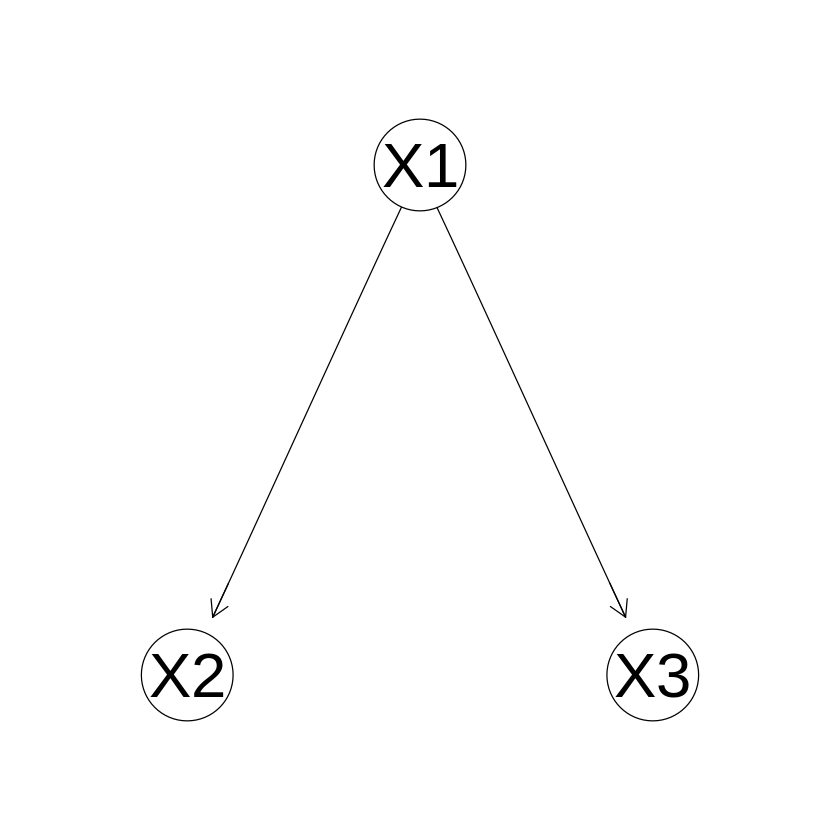

In [145]:
ex.bn2 <- model2network("[X1][X2|X1][X3|X1]")
graphviz.plot(ex.bn2)

In [148]:
# This function is very similar for the previous one but it's adapted for this other network structure
ex.probmodel2 <- function(D)
    {
        nvar <- length(names(D))
        
        # For n = 1
        col1 <- dplyr::pull(D, 1)
        nunique1 <- length(unique(col1))
        prod <- factorial(nunique1-1)
        den <- nunique - 1
        
        for(i in 1:nunique1)
            {
                prod <- prod*factorial(length(col1[col1 == unique(col1)[i]]))
                den <- den + length(col1[col1 == unique(col1)[i]])
            }
        prod <- prod/factorial(den)
    
        # For n >= 1
        for(i in 2:nvar)
            {
                col <- dplyr::pull(D, i)
                prevcol <- dplyr::pull(D, 1)
                
                r <- length(unique(col))
                q <- length(unique(prevcol))
                for(j in 1:q)
                    {
                        nij <- 0 
                        for(k in 1:r)
                            {
                                nijk <- sum(prevcol == unique(prevcol)[j] & col == unique(col)[k])
                                nij <- nij + nijk
                                prod <- prod*factorial(nijk)
                            }
                    
                        prod <- prod*factorial(r - 1)/factorial(nij + r - 1)
                    }
                
            }
    
        return(prod)
    }

ex.probmodel2(ex)

[1] 2.226854e-10

## Example with SURVEY dataset

In [12]:
# Load the dataset from the txt file
survey <- read.table("./dataset/survey.txt", header = TRUE, stringsAsFactors = TRUE)

In [13]:
# Defining the nodes and the value they assume in the dataset
nodes <- c("A", "S", "E", "O", "R", "T")

A_lvl <- c("young", "adult", "old")
S_lvl <- c("M", "F")
E_lvl <- c("high", "uni")
O_lvl <- c("emp", "self")
R_lvl <- c("small", "big")
T_lvl <- c("car", "train", "other")

In [14]:
head(survey, n=5)

,A,R,E,O,S,T
,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,adult,big,high,emp,F,car
2,adult,small,uni,emp,M,car
3,adult,big,uni,emp,F,train
4,adult,big,high,emp,M,car
5,adult,big,high,emp,M,car


In [15]:
cat('For this dataset the number of possible networks are',n.networks.structure(length(nodes)))

For this dataset the number of possible networks are 3781503

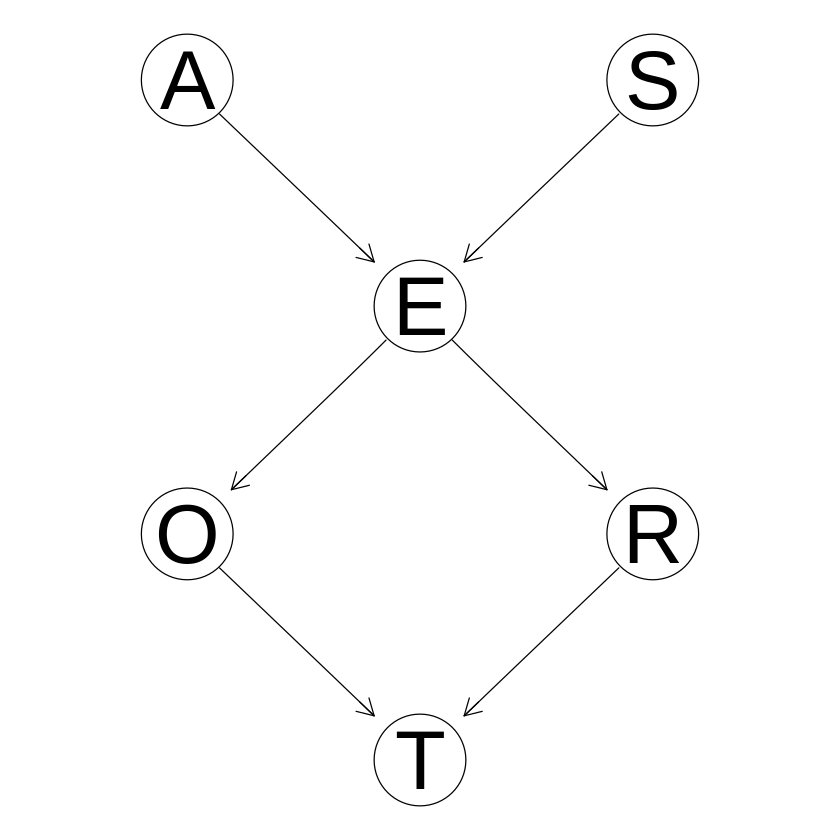

In [18]:
goal.bn <- model2network("[A][S][E|A:S][O|E][R|E][T|O:R]")
graphviz.plot(goal.bn)

# Dataset

#### Info:
https://rdrr.io/cran/bnlearn/man/alarm.html \
https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm